<a href="https://colab.research.google.com/github/ayrna/deep-learning-with-python-notebooks/blob/master/chapter03_introduction-to-keras-and-tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este cuaderno está basado en los cuadernos del libro [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff).

> This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.
> **If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**
> This notebook was generated for TensorFlow 2.6.

# Introducción a Keras y TensorFlow

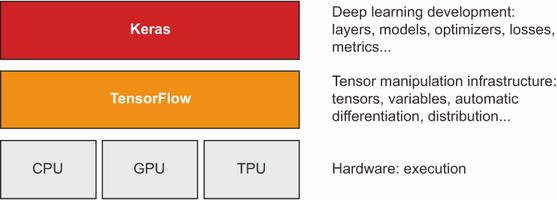

## Primeros pasos con TensorFlow

Entrenar redes neuronales gira en torno a varios conceptos: 

1. La manipulación de tensores, la *infraestructura* que subyace a todo el aprendizaje automático moderno. Esto se traduce en las APIs de **TensorFlow**:
 * *Tensores*, incluyendo tensores especiales que almacenan el estado de la red (variables)
 * *Operaciones de tensor* como la `suma`, `relu`, `matmul`
 * *Retropropagación (Backpropagation)*, una forma de calcular el gradiente de expresiones matemáticas (usado TensorFlow a través del objeto `GradientTape`)
2. Conceptos de aprendizaje profundo de alto nivel. Esto se traduce en las APIs de **Keras**:
 * *Capas*, que se combinan en un modelo
 * *Función de pérdida*, que define la señal de retroalimentación utilizada para el aprendizaje
 * *Optimizador*, que determina cómo se realiza el ajuste/aprendizaje a los datos.
 * *Métricas* para evaluar el rendimiento del modelo, como la precisión
 * Un *bucle de entrenamiento* que realiza el descenso de gradiente estocástico en mini lotes

#### Tensores constantes y variables

Los tensores son la estructura de datos básica de TensorFlow y Keras. Deben crearse con un contenido y no se les puede asignar un valor. 

Cuando es necesario cambiar el estado de una variable necesitaremos el tipo `tf.Variable`, que deben crearse con un valor inicial también. 

**All-ones o all-zeros tensors**

In [1]:
import tensorflow as tf
x = tf.ones(shape=(2, 1))
print(x)

tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)


In [2]:
x = tf.zeros(shape=(2, 1))
print(x)

tf.Tensor(
[[0.]
 [0.]], shape=(2, 1), dtype=float32)


**Tensores aleatorios**

In [3]:
x = tf.random.normal(shape=(3, 1), mean=0., stddev=1.)
print(x)

tf.Tensor(
[[-1.7668315 ]
 [-0.25729308]
 [ 1.1382235 ]], shape=(3, 1), dtype=float32)


In [4]:
x = tf.random.uniform(shape=(3, 1), minval=0., maxval=1.)
print(x)

tf.Tensor(
[[0.56428003]
 [0.79063845]
 [0.30338252]], shape=(3, 1), dtype=float32)


**Los arrays de NumPy son asignables pero los tensores no**

In [5]:
import numpy as np
x = np.ones(shape=(2, 2))
x[0, 0] = 0.

In [6]:
try:
  x = tf.ones(shape=(2, 2))
  x[0, 0] = 0.
except Exception as e:
  print(e)

'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment


**Crear un TensorFlow variable**

In [7]:
v = tf.Variable(initial_value=tf.random.normal(shape=(3, 1)))
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[-0.18002914],
       [-0.2258758 ],
       [-0.05405404]], dtype=float32)>


**Asignar un valor a un TensorFlow variable**

In [8]:
v.assign(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [1.]], dtype=float32)>

**Asignar un valor a un subconjunto de un TensorFlow variable**

In [9]:
v[0, 0].assign(3.)

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[3.],
       [1.],
       [1.]], dtype=float32)>

**Suma con `assign_add`**

In [10]:
v.assign_add(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[4.],
       [2.],
       [2.]], dtype=float32)>

#### Operaciones matemáticas con Tensores

**Operaciones básicas**

In [11]:
a = tf.ones((2, 2))
b = tf.square(a)
c = tf.sqrt(a)
d = b + c
e = tf.matmul(a, b)
e *= d

#### GradientTape API

**Cómo usar `GradientTape`**

Basta con abrir un *ámbito* de `GradientTape`, aplicar algún cálculo a uno o varios tensores de entrada, y recuperar el gradiente del resultado con respecto a las entradas.

$f(x)=x^2$

$
\frac{\partial f}{\partial x} = 2x
$



In [12]:
input_var = tf.Variable(initial_value=3.)
with tf.GradientTape() as tape:
   result = tf.square(input_var) 
gradient = tape.gradient(result, input_var)
# la función sería f(x)=x^2; f'(x)=2x, siendo x = 3 f'(x)=6
print(input_var)
print(gradient)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.0>
tf.Tensor(6.0, shape=(), dtype=float32)


**`GradientTape` con tensores constantes como entrada**

Hasta ahora, sólo hemos visto el caso en que los tensores de entrada en `tape.gradient()` eran variables TensorFlow. En realidad es posible que estas entradas sean cualquier tensor arbitrario. Sin embargo, sólo las variables entrenables son *rastreadas* por defecto. Con un tensor constante, hay que marcarlo manualmente como rastreado llamando a `tape.watch()` sobre él. Esto se hace por motivos de eficiencia computacional.

In [13]:
input_const = tf.constant(3.)
with tf.GradientTape() as tape:
   tape.watch(input_const)
   result = tf.square(input_const)
gradient = tape.gradient(result, input_const)
print(result)
print(gradient)

tf.Tensor(9.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)


#### Un clasificador lineal completo en TensorFlow

**Generación del conjunto de datos**

In [14]:
num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)

In [15]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

In [16]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))

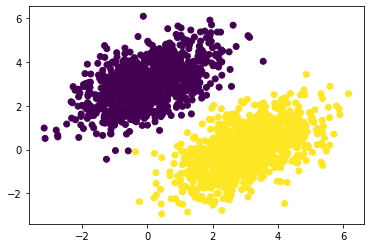

In [17]:
import matplotlib.pyplot as plt
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

**Creación de la variables del modelo lineal**

Inicializamos `W` con valores aleatorios y `b` a cero.


In [18]:
input_dim = 2
output_dim = 1
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

In [19]:
#ejemplo
print(W)
print(b)
x = tf.Variable(initial_value=[[0.2,0.2]])
tf.matmul(inputs, W) + b

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[0.4511025],
       [0.5907929]], dtype=float32)>
<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>


<tf.Tensor: shape=(2000, 1), dtype=float32, numpy=
array([[1.4816215 ],
       [2.5022907 ],
       [0.79424286],
       ...,
       [0.98666483],
       [1.921316  ],
       [1.9266548 ]], dtype=float32)>

**Propagación hacia delante**

In [20]:
def model(inputs):
    return tf.matmul(inputs, W) + b

**Función de pérdia de error cuadrático medio (MSE)**

* `persample_loss` es un tensor con la misma forma que targets y predictions y almacenará la pérdida correspondiente a cada patrón.
* Devolvemos la contribución media al error del lote. `reduce_mean` por defecto reduce todas las dimensiones a 1, pero podría utilizarse para calcular medias por ejes del tensor. 

In [21]:
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

**El paso de entrenamiento**

Recordad que `GradientTape` nos permite derivar respecto a listas de parámetros. En este caso nos devuelve el gradiente parcial respecto a cada parámetro de la lista. 

In [22]:
learning_rate = 0.1
#learning_rate = 0.0001

def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(targets, predictions)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    # Actualizamos los pesos restando el gradiente (dirección contraria)
    W.assign_sub(grad_loss_wrt_W * learning_rate)
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

**Bucle de aprendizaje con el conjunto completo (batch training)**

Para simplificar, haremos un entrenamiento por lotes en lugar de un mini-entrenamiento por lotes: ejecutaremos cada paso de entrenamiento (cálculo del gradiente y actualización de pesos) para todos los datos, en lugar de iterar sobre los datos en pequeños lotes. 

Esto significa que cada paso de entrenamiento tardará mucho más tiempo en ejecutarse pero cada actualización del gradiente será mucho más eficaz para reducir la función de pérdida al incluir todos los datos de entrenamiento. Esto significa que harán falta menos pasos de entrenamiento y que la tasa de aprendizaje debería ser mayor que al utilizar lotes pequeños (`learning_rate = 0.1`). 

❓❓❓ **EJERCICIO**
* Prueba a utilizar distintas tasas de aprendizaje en este ejemplo y observa el resultado <br>
Numeros pequeños no llega a converger, con un número muy grande se puede salir hasta infinito.
* ¿[Tiene sentido que la tasa de aprendizaje sea mayor que 1](https://ai.stackexchange.com/questions/23740/why-is-the-learning-rate-generally-beneath-1)?<br>
El valor de la pendiente machacaría los pesos.
* Intenta programar otra función de pérdida: el RMSE.
* ¿Cómo incluirías un término de regularización en la función de pérdida?

❓❓❓

In [23]:
for step in range(40):
    loss = training_step(inputs, targets)
    print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 2.5037
Loss at step 1: 0.3901
Loss at step 2: 0.1629
Loss at step 3: 0.1246
Loss at step 4: 0.1120
Loss at step 5: 0.1034
Loss at step 6: 0.0961
Loss at step 7: 0.0894
Loss at step 8: 0.0834
Loss at step 9: 0.0779
Loss at step 10: 0.0730
Loss at step 11: 0.0685
Loss at step 12: 0.0644
Loss at step 13: 0.0607
Loss at step 14: 0.0573
Loss at step 15: 0.0543
Loss at step 16: 0.0515
Loss at step 17: 0.0490
Loss at step 18: 0.0467
Loss at step 19: 0.0446
Loss at step 20: 0.0427
Loss at step 21: 0.0410
Loss at step 22: 0.0395
Loss at step 23: 0.0381
Loss at step 24: 0.0368
Loss at step 25: 0.0356
Loss at step 26: 0.0346
Loss at step 27: 0.0336
Loss at step 28: 0.0327
Loss at step 29: 0.0320
Loss at step 30: 0.0312
Loss at step 31: 0.0306
Loss at step 32: 0.0300
Loss at step 33: 0.0295
Loss at step 34: 0.0290
Loss at step 35: 0.0285
Loss at step 36: 0.0281
Loss at step 37: 0.0278
Loss at step 38: 0.0274
Loss at step 39: 0.0271


Como vemos la función de pérdida más o menos se estabiliza.

Ahora vamos a predecir la clase de los patrones. En este ejemplo de clasificación binaria el umbral de decisión entre las clases es `0.5` donde se asigna la clase "1" para los valores mayores que el umbral.

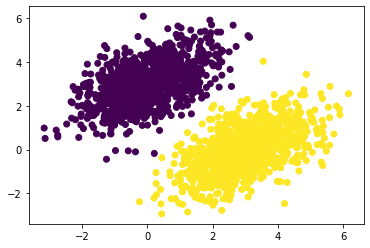

In [24]:
predictions = model(inputs)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

Además, podemos dibujar nuestro modelo de decisión, que lo constituye la línea que separa las dos clases, esto es:

```
w1 * x + w2 * y + b = 0.5
y = - w1 / w2 * x + (0.5 - b) / w2
```



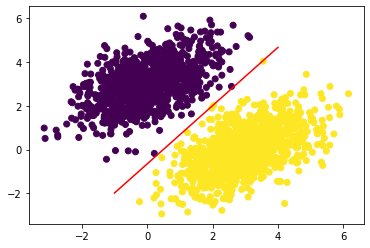

In [25]:
x = np.linspace(-1, 4, 100)
y = - W[0] /  W[1] * x + (0.5 - b) / W[1]
plt.plot(x, y, "-r")
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)

## Anatomía de una red neuronal para entender conceptos de Keras

### Capas (Layers)

La estructura de datos fundamental en las redes neuronales es la *capa*. Una capa es un módulo de procesamiento de datos que toma como entrada uno o más tensores y que da como salida uno o más tensores. Algunas capas no tienen estado, pero lo más frecuente es que las capas tengan un estado: los *pesos* de la capa, uno o varios tensores aprendidos con el descenso por gradiente, que en conjunto almacenan el *conocimiento* de la red.

Según el tipo de dato con el que trabajemos habrá tipos de capas más apropiados para trabajar con estos. 
* Datos vectoriales simples, también llamados tabulares ("hoja de cálculo"), almacenados en tensores de rango 2 `(muestra, características)`, suelen ser procesados por capas densamente conectadas, también llamadas capas totalmente conectadas (la clase `Dense` en Keras). Los datos con disposición temporal o de secuencia, tensores de rango 3 `(muestras, pasos de tiempo, características)`, se procesan normalmente por capas recurrentes, como una capa `LSTM`, o capas de convolución 1D (`Conv1D`). Los datos de imágenes, almacenados en tensores de rango 4, suelen ser procesados por capas de convolución 2D (`Conv2D`).

#### La clase `Layer` en Keras


Casi todo en Keras gira en torno a un objeto de tipo Layer, que encapsula un estado de los pesos y un cálculo sobre la red (*forward pass*). Los pesos se definen en `build()` y el procesamiento en `call()`.


**Una capa `Dense` implementada como subclase de `Layer`**

In [26]:
from tensorflow import keras

class SimpleDense(keras.layers.Layer):

    def __init__(self, units, activation=None):
        super().__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W = self.add_weight(shape=(input_dim, self.units),
                                 initializer="random_normal")
        self.b = self.add_weight(shape=(self.units,),
                                 initializer="zeros")

    def call(self, inputs):
        y = tf.matmul(inputs, self.W) + self.b
        if self.activation is not None:
            y = self.activation(y)
        return y

Esta capa que hemos creado se puede instanciar y usarse como una función: 

In [27]:
my_dense = SimpleDense(units=32, activation=tf.nn.relu)
input_tensor = tf.ones(shape=(2, 784))
output_tensor = my_dense(input_tensor)
print(output_tensor.shape)

(2, 32)


In [28]:
my_dense = SimpleDense(units=512, activation=tf.nn.tanh)
input_tensor = tf.ones(shape=(2, 784))
output_tensor = my_dense(input_tensor)
print(output_tensor.shape)

(2, 512)


#### Deducción de la forma de la capa automática: construcción de capas sobre la marcha

En Keras en general sólo necesitaremos especificar la forma de los tensores de salida de la capa, ya que las capas que se añaden al modelo se construyen dinámicamente para adaptar cada capa a la forma de la capa de entrada (la salida de la capa anterior).

La siguiente capa sólo puede conectarse a una capa que espere vectores de 32 dimensiones como entrada.

In [29]:
from tensorflow.keras import layers
layer = layers.Dense(32, activation="relu")

En Keras, no se implementa la construcción de la capa del todo en el constructor `__build__()` en espera de conocer cuál será la forma de la entrada desde la capa anterior. 

In [30]:
from tensorflow.keras import models
from tensorflow.keras import layers
model = models.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(32)
])

En el ejemplo de red que hicimos desde cero necesitábamos especificar perfectamente las dimensiones de entrada y salida de la secuencia de capas: 

```
model = NaiveSequential([
    NaiveDense(input_size=784, output_size=32, activation="relu"),
    NaiveDense(input_size=32, output_size=64, activation="relu"),
    NaiveDense(input_size=64, output_size=32, activation="relu"),
    NaiveDense(input_size=32, output_size=10, activation="softmax")
])
```



En Keras basta con lo siguiente:

In [31]:
model = keras.Sequential([
    SimpleDense(32, activation="relu"),
    SimpleDense(64, activation="relu"),
    SimpleDense(32, activation="relu"),
    SimpleDense(10, activation="softmax")
])

### De las capas a los modelos

Un modelo de aprendizaje profundo consiste en un grafo de capas, clase `Model` en Keras. Hasta ahora sólo hemos visto el modelo `Sequential`, que es una subclase de `Model` pero existen muchas otras topologías de red más avanzadas (Transformers, Residual...)

### El paso "compile" step para configurar el proceso de aprendizaje

Aquí vamos a configurar: 
* Función de pérdida (o función objetivo).
* El optimizador.
* Métricas de evaluación sobre el conjunto de train y opcionalmente validación.

In [32]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer="rmsprop",
              loss="mean_squared_error",
              metrics=["accuracy"])

In [33]:
model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

### La importancia de la función de pérdida ❗❗❗❗

La elección de la función de pérdida correcta para el problema adecuado es extremadamente importante: la red tomará cualquier atajo que pueda para minimizar la pérdida, por lo que si el objetivo no está totalmente correlacionado con la tarea en cuestión, la red terminará haciendo cosas que probablemente no queramos. 

Ejemplos: 
* ¿detector de emociones? 
* ¿maximizar el bienestar promedio de los seres humanos?

### El método fit()

**Calling `fit()` with NumPy data**

In [34]:
history = model.fit(
    inputs,
    targets,
    epochs=5,
    batch_size=128
)

Epoch 1/5
16/16 [==============================] - 1s 3ms/step - loss: 11.0202 - binary_accuracy: 0.0870
Epoch 2/5
16/16 [==============================] - 0s 3ms/step - loss: 10.6295 - binary_accuracy: 0.0915
Epoch 3/5
16/16 [==============================] - 0s 2ms/step - loss: 10.3000 - binary_accuracy: 0.0930
Epoch 4/5
16/16 [==============================] - 0s 2ms/step - loss: 9.9786 - binary_accuracy: 0.0950
Epoch 5/5
16/16 [==============================] - 0s 4ms/step - loss: 9.6638 - binary_accuracy: 0.0985


In [35]:
history.history

{'loss': [11.020177841186523,
  10.629515647888184,
  10.299980163574219,
  9.978599548339844,
  9.663833618164062],
 'binary_accuracy': [0.08699999749660492,
  0.09149999916553497,
  0.09300000220537186,
  0.0949999988079071,
  0.09849999845027924]}

### Monitorización de la pérdida y las métricas sobre datos de validación

**Parámetro `validation_data`**


In [36]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.1),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

indices_permutation = np.random.permutation(len(inputs))
shuffled_inputs = inputs[indices_permutation]
shuffled_targets = targets[indices_permutation]

num_validation_samples = int(0.3 * len(inputs))
val_inputs = shuffled_inputs[:num_validation_samples]
val_targets = shuffled_targets[:num_validation_samples]
training_inputs = shuffled_inputs[num_validation_samples:]
training_targets = shuffled_targets[num_validation_samples:]
model.fit(
    training_inputs,
    training_targets,
    epochs=5,
    batch_size=16,
    validation_data=(val_inputs, val_targets)
)

Epoch 1/5
88/88 [==============================] - 1s 8ms/step - loss: 0.1160 - binary_accuracy: 0.9450 - val_loss: 0.0432 - val_binary_accuracy: 0.9883
Epoch 2/5
88/88 [==============================] - 1s 7ms/step - loss: 0.0731 - binary_accuracy: 0.9550 - val_loss: 0.5185 - val_binary_accuracy: 0.6933
Epoch 3/5
88/88 [==============================] - 1s 6ms/step - loss: 0.0699 - binary_accuracy: 0.9586 - val_loss: 0.1114 - val_binary_accuracy: 0.8533
Epoch 4/5
88/88 [==============================] - 1s 12ms/step - loss: 0.0801 - binary_accuracy: 0.9543 - val_loss: 0.0266 - val_binary_accuracy: 0.9967
Epoch 5/5
88/88 [==============================] - 1s 9ms/step - loss: 0.0661 - binary_accuracy: 0.9593 - val_loss: 0.1869 - val_binary_accuracy: 0.7667


### Cómo usar el modelo entrenado

Se puede llamar al modelo como una función, pero esto evaluaría toda la base de datos de test directamente en lugar de por lotes.

```
predictions = model(new_inputs)
```

Habitualmente será más adecuado usar la función `predict`

In [37]:
predictions = model.predict(val_inputs, batch_size=128)
print(predictions[:10])

5/5 [==============================] - 0s 2ms/step
[[ 0.01802078]
 [ 0.9033823 ]
 [ 0.4656409 ]
 [ 0.396976  ]
 [ 0.8399668 ]
 [ 0.50083077]
 [-0.05368209]
 [ 0.3029549 ]
 [ 0.60835516]
 [-0.08410373]]


#❓❓❓
**EJERCICIO**

* Prueba a utilizar el modelo anterior de 4 capas con la base de datos MNIST 
* Prueba a añadir más métricas de rendimiento
* Prueba a visualizar el historial de ajuste del modelo

❓❓❓

11490434/11490434 [==============================] - 1s 0us/step
Epoch 1/5
469/469 [==============================] - 6s 7ms/step - loss: 0.5699 - Accuracy: 0.8319
Epoch 2/5
469/469 [==============================] - 3s 7ms/step - loss: 0.2585 - Accuracy: 0.9237
Epoch 3/5
469/469 [==============================] - 3s 6ms/step - loss: 0.1889 - Accuracy: 0.9445
Epoch 4/5
469/469 [==============================] - 2s 5ms/step - loss: 0.1503 - Accuracy: 0.9555
Epoch 5/5
469/469 [==============================] - 3s 5ms/step - loss: 0.1225 - Accuracy: 0.9635
accuracy: 0.96


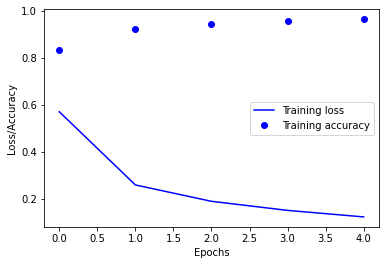

In [38]:
#0. Cargar datos
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

#1.Definir el modelo
model = keras.Sequential([
    SimpleDense(32, activation=tf.nn.relu),
    SimpleDense(256, activation=tf.nn.relu),
    SimpleDense(32, activation=tf.nn.relu),
    SimpleDense(10, activation=tf.nn.softmax)
])

#2.Configurar el optimizador
model.compile(optimizer="Adam",
              loss="sparse_categorical_crossentropy",
              metrics=["Accuracy"])

#3. Fit
history = model.fit(
    train_images,
    train_labels,
    epochs=5,
    batch_size=128
)

#4. Prediccion
import numpy as np
predictions = model(test_images)
predictions = predictions.numpy()
predicted_labels = predictions.argmax(axis = 1) # CAMBIAR AQUÍ
matches = predicted_labels == test_labels
print(f"accuracy: {matches.mean():.2f}")

# Puedes usar este código para visualizar el histórico de entrenamiento
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
acc_values = history_dict["Accuracy"]
plt.plot(loss_values, "b-", label="Training loss")
plt.plot(acc_values, "bo", label="Training accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend()

## Resumen
* TensorFlow es un *framework* que puede ejecutarse en CPU, GPU y TPU.
* TensorFlow puede calcular el gradiente de cualquier expresión diferenciable. 
* Keras es un API para hacer modelos de aprendizaje profundo con TF.
* Objetos claves de TF: tensores, variables, operaciones con tensores y *GradientTape*. 
* La clase central de Keras es `Layer`, que encapsula algunos pesos y cálculos. Las capas se unen o ensamblan en **modelos**.
* Antes de entrenar un modelo es necesario elegir un **optimizador**, una **función de pérdida** y una o varias **métricas**: `model.compile()`
* El método `model.fit()` ejecuta el descenso por gradiente por mini-lotes. Permite monitorizar la pérdida y métricas y incluir datos de **validación**.
* Con el modelo entrenado, se pueden hacer predicciones con `model.predict()`.